# Modeling MNIST using a CNN

## Resources
1. [KL-divergent](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained)
2. [Evidence Lower Bound](https://www.cs.cmu.edu/~epxing/Class/10708-15/notes/10708_scribe_lecture13.pdf)

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

Test Brier Score Loss

In [5]:
from sklearn.metrics import brier_score_loss as bl
y_true = np.array([[0, 1, 1, 0], [0, 1, 1, 0]])
y_prob = np.array([[0.1, 0.9, 0.8, 0.25], [0.1, 0.9, 0.8, 0.3]])
sk_result = bl(y_true[0], y_prob[0])

def brier_score_loss(prob, targets):
    assert prob.size() == targets.size(), \
    "pro shape {} differs from targets shape {}".format(prob.size(), targets.size())
    #using -1 so that either one dimension or two dimension both works
    tally = torch.mean(torch.pow(prob - targets, 2), dim=-1) #b * c
    #print('tally', tally)
    return torch.mean(tally, dim=0)
    

y_true = torch.tensor(y_true)
y_prob = torch.tensor(y_prob)

py_result = brier_score_loss(y_prob, y_true)
print('my result', py_result)

mseloss = torch.nn.MSELoss(reduction='mean')
print('mse', mseloss(y_prob, y_true))

y_true = np.ones((2, 3))
y_prob = np.zeros((2, 3))
for i in range(y_true.shape[0]):
    sk_result = bl(y_true[i], y_prob[i])
    print(sk_result)
y_true = torch.tensor(y_true)
y_prob = torch.tensor(y_prob)
py_result = brier_score_loss(y_prob, y_true)
print(py_result)

my result tensor(0.0341, dtype=torch.float64)
mse tensor(0.0341, dtype=torch.float64)
1.0
1.0
tensor(1., dtype=torch.float64)


## Train neural network on MNIST data

Define network structures and loss functions

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(5*5*64, 10)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*64)
        return self.fc1(x)

Set up loss function, set it to `bce` to use multi-label cross entropy loss.

In [7]:
LOSS_TYPE = 'mse'
loss_fun = brier_score_loss if LOSS_TYPE == 'mse' else nn.BCEWithLogitsLoss()

Create the network and load the datasets.

In [8]:
model = Net()
batch_size_train = 256
batch_size_test = 1000
num_classes = 10

Load not mnist dataset

In [9]:
import glob
import numpy as np
from PIL import Image
# https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

root_dir = '/mnt/shared/liyin/public_html/not_mnist_dataset/notMNIST_small'

letter_labels = {k: chr(v) for k, v in zip(range(10), range(ord('A'), ord('A')+10))}
counter = {k: 0 for k, v in zip(range(10), [0]*10)}

def load_not_mnist():
    glob.glob(f'{root_dir}/[A-J]') #f'{root_dir}/**/'
    labels = []
    images = []
    for subpath in glob.glob(f'{root_dir}/[A-J]/'):
        label = subpath.split('/')[-2]
        int_label = ord(label) - ord('A')
        count = 0
        for img_path in glob.glob(f'{subpath}*.png'):
            try:
                image = Image.open(img_path)
            except IOError:
                print(f'cant open image {img_path}')
                continue
            count += 1
            image = np.asarray(image)
            images.append(image)
            labels.append(int_label)
            counter[int_label] += 1
            if count == 1000:
                break
    labels = np.stack(labels, axis=0).astype(np.uint8)
    images = np.stack(images, axis=0)
    print(labels.shape, images.shape)
    return images, labels

In [10]:
images, labels = load_not_mnist()

cant open image /mnt/shared/liyin/public_html/not_mnist_dataset/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png
(10000,) (10000, 28, 28)


Load Fashion MNIST

In [11]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [12]:
root_dir_fashion = root_dir_fashion = '/mnt/shared/liyin/public_html/fashion_mnist_datasets/'
X_train, y_train = load_mnist(root_dir_fashion, kind='train')
X_test, y_test = load_mnist(root_dir_fashion, kind='t10k')

In [13]:
print(X_test.shape, y_test.shape)
y_test
#np.reshape(X_test[0], (28, 28))

(10000, 784) (10000,)


array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [14]:
# Customize a dataset
from torch.utils.data import Dataset
from PIL import Image

class FashionMNISTDataset(Dataset):
    def __init__(self, data, targets, train=True, transform=None, target_transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(np.reshape(img, (28, 28)), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)
    
class NotMNISTDataset(Dataset):
    def __init__(self, data, targets, train=True, transform=None, target_transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img, mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

In [15]:
def load_fashion_mnist_data(batch_size_train, batch_size_test, X_train, y_train, X_test, y_test, dataset = FashionMNISTDataset):
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    train_loader = None
    test_loader = None
    
    if X_train is not None and y_train is not None:

        train_loader = torch.utils.data.DataLoader(
          dataset(X_train, y_train, transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                         (0.1307,), (0.3081,))
                                     ])),
          batch_size=batch_size_train, shuffle=True)
    
    if X_test is not None and y_test is not None:
        test_loader = torch.utils.data.DataLoader(
          dataset(X_test, y_test, transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                         (0.1307,), (0.3081,))
                                     ])),
          batch_size=batch_size_test, shuffle=True)
    return (train_loader, test_loader)

## Ensemling Training

Set a total of 5 networks, and each is trained independently. The final prediction comes with the averaged output.

In [16]:
import numpy as np
def load_mnist_train_data(batch_size_train, num_loaders):
    root_dir = '/mnt/homedir/jaix/public_html/mnist_datasets/'

    return [torch.utils.data.DataLoader(
      torchvision.datasets.MNIST(root=root_dir, train=True, download=False,
                                 transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
      batch_size=batch_size_train, shuffle=True) for _ in range(num_loaders)]

def load_mnist_test_data(batch_size_test):
    root_dir = '/mnt/homedir/jaix/public_html/mnist_datasets/'  
    test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST(root=root_dir, train=False, download=False,
                                 transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
      batch_size=batch_size_test, shuffle=True)
    return test_loader


def train_ensemble(log_interval, models, train_loaders, optimizers, epoch):
    #assert torch.equal(models[0].conv1.weight.data, models[1].conv1.weight.data) == False

    for model in models:
        model.train()

    #loss_fun = nn.CrossEntropyLoss()
    for batch_idx, batch_datas in enumerate(zip(*train_loaders)):
        # Make sure each model takes different data at each batch
        #assert torch.equal(batch_datas[0][1], batch_datas[1][1]) == False
        losses = []

        for model_idx, (data, target) in enumerate(batch_datas):
            optimizers[model_idx].zero_grad()
            output = models[model_idx](data)
            if LOSS_TYPE == 'mse':
                output = F.softmax(output, dim=1)
            #assert torch.abs(torch.sum(output[0])-1.0) <= 1e-6, '{}'.format(torch.sum(output[0]))

            one_hot_target =(target.unsqueeze_(dim=1) == torch.arange(num_classes).reshape(1, num_classes)).float()          
            
            loss = loss_fun(output, one_hot_target.squeeze_(dim=1)) # multi-label cross entropy loss
            loss.backward()
            optimizers[model_idx].step()
            losses.append(loss)
        mean_loss = torch.mean(torch.stack(losses), dim=0)

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loaders[0].dataset),
                100. * batch_idx / num_iterations, mean_loss.item()))
        #return

def test_ensemble(models, test_loader):
    for model in models:
        model.eval()
    model_losses = [0] * len(models)
    model_accs = [0] * len(models)
    model_pros = [0] * len(models)
    ensemble_acc = 0
    ensemble_pro = 0
    single_pro = 0
    ensembe_variation = 0
    with torch.no_grad():   
        for data, target in test_loader:
            outputs = []
            test_losses=[]
            accs = []
            for idx, model in enumerate(models):
                output = model(data)
                target_unsqueeze = torch.unsqueeze(target, dim=1)
                one_hot_target =(target_unsqueeze == torch.arange(num_classes).reshape(1, num_classes)).float()          
                one_hot_target_squeeze= torch.squeeze(one_hot_target, dim=1)
                if LOSS_TYPE == 'mse':
                    output = F.softmax(output, dim=1)

                loss = loss_fun(output, one_hot_target).item() # sum up batch loss
                if LOSS_TYPE != 'mse':
                    output = F.softmax(output, dim=1) #.type(torch.FloatTensor)    
                # get label
                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                acc = pred.eq(target.view_as(pred)).sum().item()
                prod = output.max(dim=1, keepdim=True)[0]
                outputs.append(output)
                test_losses.append(loss)
                accs.append(acc)
                model_losses[idx] += loss
                model_accs[idx] += acc
                model_pros[idx] += torch.mean(prod) # mean probability on the batch
                # make sure the output sum up to be 1
                assert torch.abs(torch.sum(output[0])-1.0) <= 1e-6, '{}'.format(torch.sum(output[0]))
            stacked_outputs = torch.stack(outputs, dim = 0)
                         
            # get the ensemled output probability            
            ensemble_output = torch.mean(stacked_outputs, dim = 0)
            # predicted labels and accuracy 
            ensemle_pred = ensemble_output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            ensemble_acc += ensemle_pred.eq(target.view_as(ensemle_pred)).sum().item()
            
            # Get ensemble probability
            pred = ensemble_output.max(dim=1, keepdim=True)[0] # convert it to probability, 1000 * 1
            ensemble_pro += torch.mean(pred)
            assert torch.abs(torch.sum(ensemble_output[0])-1.0) <= 1e-6, '{}'.format(torch.sum(ensemble_output[0]))
            
   
    avg_model_loss = np.array(model_losses) / len(test_loader)
    avg_model_acc = np.array(model_accs) / len(test_loader.dataset)
    avg_model_pro = np.array(model_pros) / len(test_loader)
    avg_ensemble_acc = ensemble_acc / len(test_loader.dataset)
    avg_ensemble_pro = ensemble_pro / len(test_loader)
    single_pro /= len(test_loader)

    print('\nTest set: Average loss: {}, Accuracy: {}/{} ({}), probabilities: {}%, Ensemble Accuray: {}%, Ensemble Prediction Score: {}. \n'.format(
        avg_model_loss, model_accs, len(test_loader.dataset),
        avg_model_acc, avg_model_pro, avg_ensemble_acc, avg_ensemble_pro ) )
    single_net_acc = avg_model_acc[0]
    ensemble_net_acc = avg_ensemble_acc
    single_net_prob = avg_model_pro[0]
    ensemble_net_prob = avg_ensemble_pro
    return (single_net_acc, ensemble_net_acc, single_net_prob, ensemble_net_prob)

In [17]:
num_networks = 5
train_loaders, test_loader = load_mnist_train_data(batch_size_train, num_networks), \
                            load_mnist_test_data(batch_size_test)

In [18]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fashion_train_loader, fashion_test_loader = load_fashion_mnist_data(batch_size_train, batch_size_test, X_train, y_train, 
                                                                    X_test, y_test)
fashion_train_loader, fashion_test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7fc8ac71b310>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc8ac71b4d0>)

In [19]:
_, not_mnist_test_loader = load_fashion_mnist_data(batch_size_train, batch_size_test, None, None,
                                                   images, labels, dataset=NotMNISTDataset)
not_mnist_test_loader

Visualize the datasets

In [20]:
def plot_first_6(x, y, classes):
    fig = plt.figure()
    for i in range(6):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      plt.imshow(x[i][0], cmap='gray', interpolation='none')
      label = y[i].data.item()
      plt.title("Prediction: {}".format(
        classes[label]))
      plt.xticks([])
      plt.yticks([])
    fig



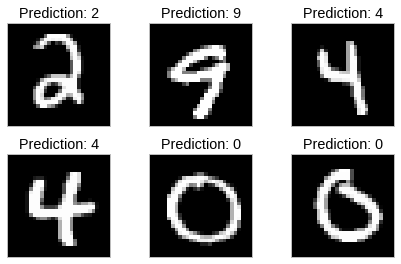

In [21]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
plot_first_6(example_data, example_targets, classes={k: v for k, v in zip(range(10), range(10))})

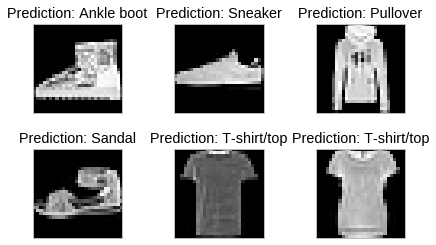

In [22]:
examples = enumerate(fashion_test_loader)
batch_idx, (example_data, example_targets) = next(examples)
plot_first_6(example_data, example_targets, classes)

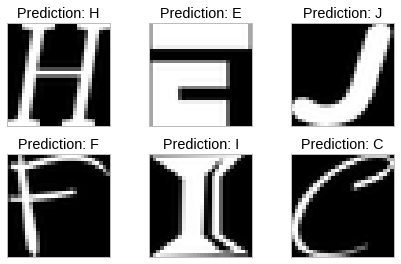

In [23]:
examples = enumerate(not_mnist_test_loader)
batch_idx, (example_data, example_targets) = next(examples)
plot_first_6(example_data, example_targets, letter_labels)

Train the ensemble model: 20 epochs with adam optimizer

In [ ]:
log_interval = 100
learning_rate = 0.005 #0.005 for Adam optimizer, > 0.05 for SGD optimizer
momentum = 0.9
n_epochs = 20

models = [Net() for _ in range(num_networks)]
optimizers = [optim.Adam(model.parameters(), lr=learning_rate) for model in models]


num_iterations = len(train_loaders[0])


#torch.manual_seed(1)
mnist_data = []
fashionmnist_data = []
notmnist_data = []

for epoch in range(1, n_epochs + 1):
    train_ensemble(log_interval, models, train_loaders, optimizers, epoch)
    
    mnist_data.append(test_ensemble(models, test_loader))
    fashionmnist_data.append(test_ensemble(models, fashion_test_loader))
    notmnist_data.append(test_ensemble(models, not_mnist_test_loader))
    
for i in range(num_networks):
    torch.save(models[i].state_dict(),"mnist_cnn_cross_entropy{}.pt".format(i))

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.090733
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.004728
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.003632

Test set: Average loss: [0.00335951 0.00250981 0.00239486 0.00260411 0.00292401], Accuracy: [9788, 9832, 9849, 9826, 9807]/10000 ([0.9788 0.9832 0.9849 0.9826 0.9807]), probabilities: [0.9807345  0.97684014 0.98240185 0.98413277 0.9836049 ]%, Ensemble Accuray: 0.9864%, Ensemble Prediction Score: 0.9771267771720886. 


Test set: Average loss: [0.14635367 0.11906421 0.12724103 0.13473308 0.13462244], Accuracy: [829, 1181, 984, 531, 580]/10000 ([0.0829 0.1181 0.0984 0.0531 0.058 ]), probabilities: [0.73596936 0.56416726 0.6175355  0.61845565 0.63846964]%, Ensemble Accuray: 0.075%, Ensemble Prediction Score: 0.5544369220733643. 


Test set: Average loss: [0.1454648  0.14397165 0.14371834 0.14265257 0.14036608], Accuracy: [1520, 1414, 1313, 1385, 1511]/10000 ([0.152  0.1414 0.1313 0.1385 0.1511]), probabilities: [0.8303641  0.8003825  0.7871755  0

In [2]:
def plot_data(mnist_data, fashionmnist_data, notmnist_data):
    # plot with various axes scales
    plt.figure(figsize=(15, 7))
    datas = [mnist_data,fashionmnist_data, notmnist_data ]
    titles = ['MNIST', 'FASHION_MNIST', 'NOT_MNIST']
    n = len(datas)

    for idx, (data, title) in enumerate(zip(datas, titles)):
        single_net_acc, ensemble_net_acc, single_net_prob, ensemble_net_prob = [], [], [], []
        for sna, ena, snp, enp in data:
            single_net_acc.append(sna)
            ensemble_net_acc.append(ena)
            single_net_prob.append(snp)
            ensemble_net_prob.append(enp)
        plot_index = f'1{n}{idx+1}'      
        plt.subplot(int(plot_index))
        x = range(1, len(single_net_acc)+1)
        plt.plot(x, single_net_acc, 'bs', x, ensemble_net_acc, 'ys', x, single_net_prob, 'g^'
            , x, ensemble_net_prob, 'r*')
        plt.xlabel('epochs')

        plt.title(title)
        plt.grid(True)
    plt.legend(['single_net_acc', 'ensemble_net_acc', 'single_net_prob', 'ensemble_net_prob'], loc='bottom right')

    plt.title('Adam Optimizer, Brier Score Loss')
    plt.show()

In [ ]:
#print(mnist_data, fashionmnist_data, notmnist_data)
plot_data(mnist_data, fashionmnist_data, notmnist_data)

Train the ensemble model: 20 epochs with SGD optimizer

In [ ]:
num_networks = 5
log_interval = 100
learning_rate = 0.05
momentum = 0.9
n_epochs = 20
train_loaders, test_loader = load_mnist_train_data(batch_size_train, num_networks), \
                            load_mnist_test_data(batch_size_test)
models = [Net() for _ in range(num_networks)]
optimizers = [optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) for model in models]


num_iterations = len(train_loaders[0])


#torch.manual_seed(1)
sgd_mnist_data = []
sgd_fashionmnist_data = []
sgd_notmnist_data = []

for epoch in range(1, n_epochs + 1):
    train_ensemble(log_interval, models, train_loaders, optimizers, epoch)
    
    sgd_mnist_data.append(test_ensemble(models, test_loader))
    sgd_fashionmnist_data.append(test_ensemble(models, fashion_test_loader))
    sgd_notmnist_data.append(test_ensemble(models, not_mnist_test_loader))
    
for i in range(num_networks):
    torch.save(models[i].state_dict(),"mnist_cnn_sgd_{}.pt".format(i))

In [ ]:
plot_data(sgd_mnist_data, sgd_fashionmnist_data, sgd_notmnist_data)

## Out-of-distribution Detection

Generally, in the experiments, the ensemble model has better testing accuracy and is less confident when it comes to the out-of-distribution samples. The effect of ensemble model on the detection of out-of-distribution examples depends on **training epochs** and the **optimizer**.
* The more epochs we train the ensemble model, the more effective the ensemble model shows--less condident to the out-of-distribution examples.
* Adam optimizer makes the ensemble model more effective compared with SGD optimizer. With Adam optimizer, the experimental result is almost the same as acclaimed in the paper, but with SGD optimizer, the effect is much less and the single net model is good at detecting out-of-distribution examples itself already. 

Takeaway from the experiments: 
* SGD optimizer is better than Adam optimizer to detect out-of-distribution examples.
* To make a single model more resilent to out-of-distribution examples, avoid overfitting the model.
* Ensemble model is able to train longer, gain better accuracy, and delay the overfitting.

### Code to work around the downloading part

In [ ]:
# Work around to load the fashion dataset
import requests
from bento import fwdproxy
import shutil
from pathlib import Path
import gzip
root_dir_fashion = '/mnt/shared/liyin/public_html/fashion_mnist_datasets/'
files = ['http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz', \
         'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz', \
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz', \
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz']

with fwdproxy():
    p = Path(root_dir)
    p.mkdir(exist_ok=True)
    for file in files:
        r = requests.get(file)
        print(r.headers.get('content-type'))

        open(file.split('/')[-1], 'wb').write(r.content)
        shutil.copy(file.split('/')[-1], root_dir)
    #load_fashion_mnist_data(batch_size_train)

In [ ]:
    
import requests
from bento import fwdproxy
import shutil
from pathlib import Path
import gzip
root_dir = '/mnt/shared/liyin/public_html/not_mnist_dataset/notMNIST_small'
files = ['http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz']

with fwdproxy():
    p = Path(root_dir)
    p.mkdir(exist_ok=True)
    for file in files:
        r = requests.get(file)
        print(r.headers.get('content-type'))

        open(file.split('/')[-1], 'wb').write(r.content)
        shutil.copy(file.split('/')[-1], root_dir)

In [ ]:
! ls /mnt/shared/liyin/public_html/not_mnist_dataset/notMNIST_small